Code review for anikap22

In [1]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import packages
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as ss
import toyplot


In [3]:
# fix a random seed
np.random.seed(123)

# generate data for 199 years with higher rates before 1920
data = pd.DataFrame({
    "year": np.arange(1200, 2018),
    "seedlings": np.concatenate([
        np.random.poisson(5.0, 400),
        np.random.poisson(1, 418),
    ])
})

In [4]:
data.head()

,seedlings,year
0,7,1200
1,5,1201
2,4,1202
3,8,1203
4,4,1204


In [8]:
seeds = data.iloc[:,0] #row,col

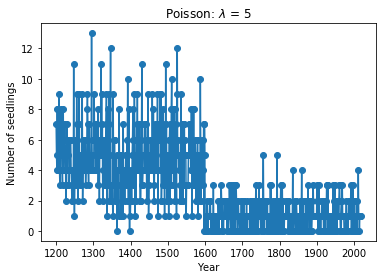

In [9]:

# plot
import matplotlib.pyplot as plt
rate = 5
n = np.arange(1200, 2018)
plt.plot(n,seeds, '-o')
plt.title('Poisson: $\lambda$ = %i' % rate)
plt.xlabel('Year')
plt.ylabel('Number of seedlings')
plt.show()

In [10]:
# plot the generated data
toyplot.scatterplot(
    data.year,
    data.seedlings, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="# Seedlings",
);

1250 1500 1750 2000 year 0 5 10 15 # Seedlings

In [11]:
with pm.Model() as seedling_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1800)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate)

    disasters = pm.Poisson('seedlings', rate, observed=data.seedlings)

In [16]:
with seedling_model:
    trace = pm.sample(100)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
 91%|█████████ | 544/600 [00:01<00:00, 277.90it/s]/Users/teachinghouse/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/teachinghouse/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

100%|██████████| 600/600 [00:02<00:00, 292.61it/s]Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


ValueError: zero-size array to reduction operation minimum which has no identity

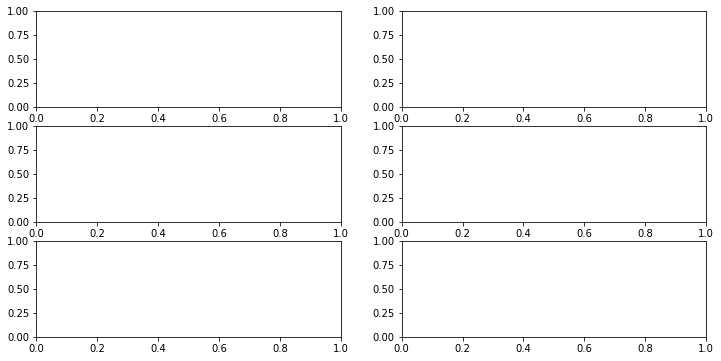

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
pm.traceplot(trace[100:])
plt.show()

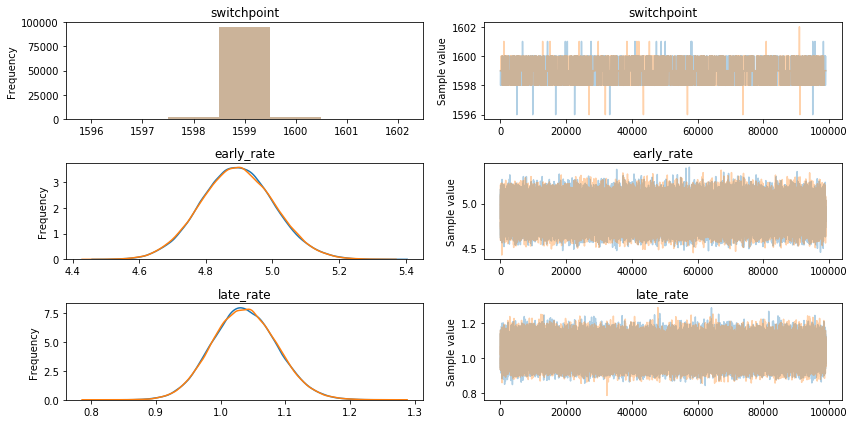

In [19]:
pm.traceplot(trace[1000:]);

In [14]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1599.575000,1.981004,0.197658,1599.000000,1606.000000,4.0,1.082663
early_rate,4.905643,0.111457,0.008412,4.677999,5.092772,136.0,0.996225
late_rate,1.035005,0.045139,0.003375,0.957918,1.134325,145.0,1.004442


Q. What method did they use to generate data? What types of distributions did they sample data from? What type of data do these distributions generate?

To generate the data, the two Poisson distributions representing before and after the switching point was concatenated by using the  Numpy concatenate function.

Q. What type of model did they try to fit with pymc3? Did they link to the tutorial that their analysis is based on. Which parameters of the model are they trying to fit.

The model used to fit the data was similar to one of the pymc3 tutorials - Case study 2: Coal mining disasters. In this model, several parameters are considered: 
Dt: The number of disasters in year t 
rt: The rate parameter of the Poisson distribution of disasters in year t. 
s: The year in which the rate parameter changes (the switchpoint). 
e: The rate parameter before the switchpoint s. 
l: The rate parameter after the switchpoint s. 
tl, th: The lower and upper boundaries of year t.

The rarameter s, the year in which the rate parameter changes (the switchpoint) was fit in this assignment.

Q. Are they sampling data in their model from the same type of distribution that was used to generate the data?

Yes, the type of distribution used to generte the data and used in the model are the Poisson distributions.

Q. Do you agree or disagree with their assessment of the model fit? Did it work well? How might you suggest improving the model, or further testing this type of model?

I agree with the assessment of the model fit. It worked well. After plotting data, I could see that the estimation of the swichpoint, early and late rate were about the same as the true values. The other parameters could be tweeked to obtain better fit for the model.